# Exploratory data analysis

In [1]:
# load json
import json
with open('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/annotation/voc_all.json') as f:
    all_data=json.load(f)
# with open('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/annotation/train_new.json') as g:
#     train=json.load(g)  
# with open('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/annotation/val_new.json') as h:
#     val=json.load(h)

In [2]:
print('number category: {}'.format(len(all_data['categories'])))
all_data['categories']

number category: 4


[{'name': 'holothurian', 'id': 1},
 {'name': 'echinus', 'id': 2},
 {'name': 'scallop', 'id': 3},
 {'name': 'starfish', 'id': 4}]

In [3]:
print('训练图片数量: {}'.format(len(all_data['images'])))
print('训练标签数量: {}'.format(len(all_data['annotations'])))

训练图片数量: 5543
训练标签数量: 41441


In [4]:
total=[]
for img in all_data['images']:
    wh=(img['width'], img['height'])
    total.append(wh)
unique=set(total)
for k in unique:
    print('长宽为({}, {})的数量: {}'.format(k[0], k[1], total.count(k)))

长宽为(704, 576)的数量: 38
长宽为(1920, 1080)的数量: 596
长宽为(3840, 2160)的数量: 1712
长宽为(720, 405)的数量: 3153
长宽为(586, 480)的数量: 44


In [5]:
anns_id = []
images_id = []
for anns in all_data['annotations']:
    anns_id.append(anns['id'])
    images_id.append(anns['image_id'])
print('训练集图片数量: ', len(all_data['images']))
print('unique id 数量: ', len(set(anns_id)))
print('unique image_id 数量: ', len(set(images_id)))

训练集图片数量:  5543
unique id 数量:  41441
unique image_id 数量:  5455


**训练图片的id数量与标注对应的图片数量不匹配**，意味着可能存在标注错误或者图片缺失，因此需要对annos作进一步过滤

### 查看缺失图片数量

In [6]:
import os
unique_image = {'{:06d}'.format(img_id) for img_id in set(images_id)}
actual_images_names = os.listdir('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/image')
actual_images_id = [img_name.split('.')[0] for img_name in actual_images_names]
origin_list = set(actual_images_id)

gaps = origin_list - unique_image
print('缺少标注的图像数量：{}'.format(len(gaps)))


缺少标注的图像数量：88


gaps的元素在origin_list中存在，但是在unique_image中不存在,有88个文件没有标注信息，annotation为空那么在训练的过程中，全图为空，没有标注的图，应该删掉，或者使用mixup，增强特征

mmdetection会自动删除全图标注为空的样本

### 查看统计量

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family']='sans-serif'
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [8]:
## 创建类别标签字典
category_dict = dict([(cate['id'], cate['name']) for cate in all_data['categories']])
category_dict

{1: 'holothurian', 2: 'echinus', 3: 'scallop', 4: 'starfish'}

In [9]:
counts_label_all=dict([(cate['name'], 0) for cate in all_data['categories']])
# counts_label_train=dict([(j['name'], 0) for j in train['categories']])
# counts_label_val=dict([(h['name'], 0) for h in val['categories']])
for anns in all_data['annotations']:
    counts_label_all[category_dict[anns['category_id']]] += 1
# for j in train['annotations']:  
#     counts_label_train[category_dic[j['category_id']]] += 1
# for n in val['annotations']:
#     counts_label_val[category_dic[n['category_id']]] += 1
    
print("总数据集每个类别的标注数量： {}".format(counts_label_all))
# print("train集每个类别的标注数量： {}".format(counts_label_train))
# print("val集每个类别的标注数量： {}".format(counts_label_val))

总数据集每个类别的标注数量： {'holothurian': 5537, 'echinus': 22343, 'scallop': 6720, 'starfish': 6841}


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


                 0
holothurian   5537
echinus      22343
scallop       6720
starfish      6841


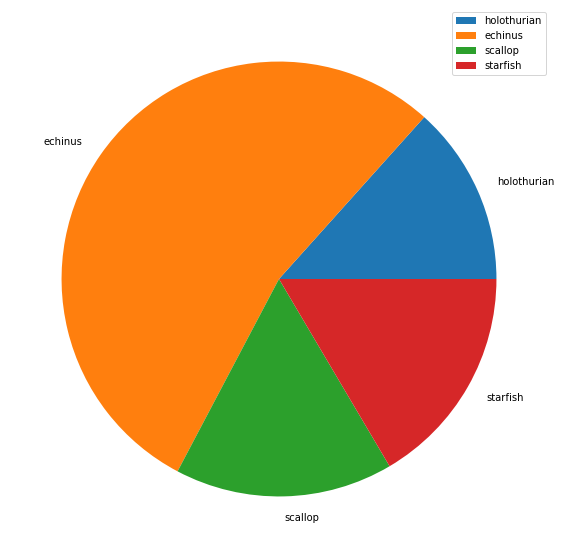

In [10]:
# 打印
%matplotlib inline 
plt.style.use({'figure.figsize':(10, 10)})
indices=counts_label_all.keys()
values=counts_label_all.values()
count_df=pd.DataFrame(list(values),index=indices)
print(count_df)
count_df.iloc[:,0].plot.pie()
plt.legend()
plt.axis('off')
plt.show()